## Модели ARIMA и GARCH

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -30.477593
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


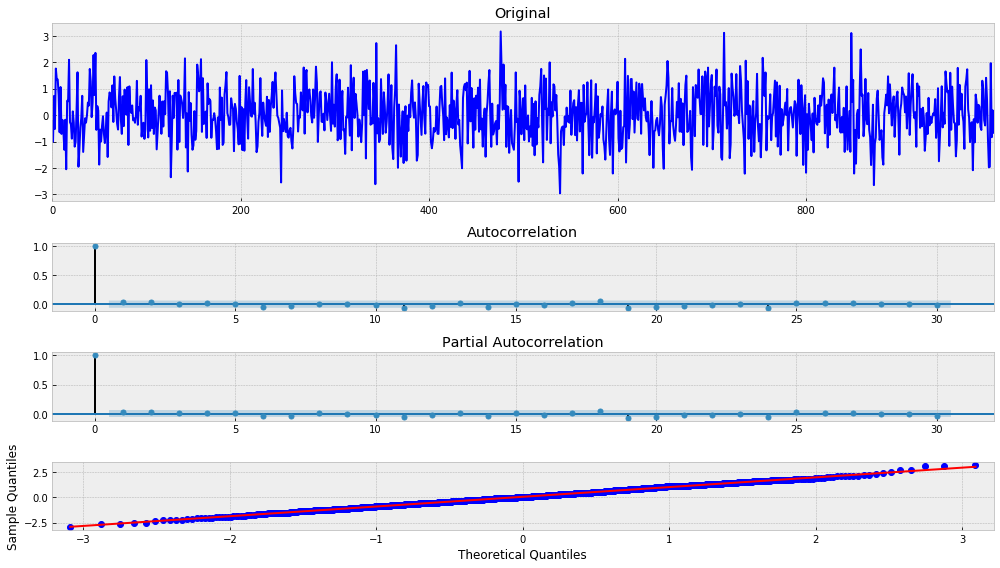

In [6]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность белого шума в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс белого шума

Results of Dickey-Fuller Test:
Test Statistic                  -3.539189
p-value                          0.007036
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


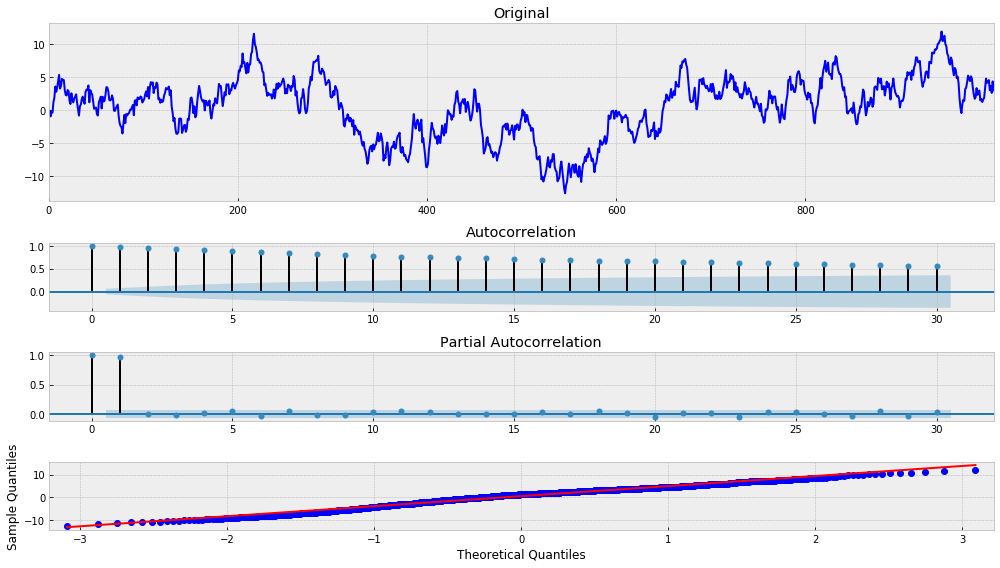

In [7]:
# 1
# n_samples = 100
# eps = np.random.normal(size=n_sample)
# x = [0]
# for i in range(1, n_samples):
#     x.append(x[i-1]+eps[i])
#
# tsplot(x, lags=30)


# 2
n_sample = 1000
x = w = np.random.normal(size=n_sample)
for t in range(n_sample):
    x[t] = x[t-1] + w[t]
    
tsplot(x, lags=30)


# 3
# x = np.random.normal(size=1000)
# x = cumsum(x)
# tsplot(x, lags=30)

Давайте проверим, подходит ли модель белого шума под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                 -31.841166
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


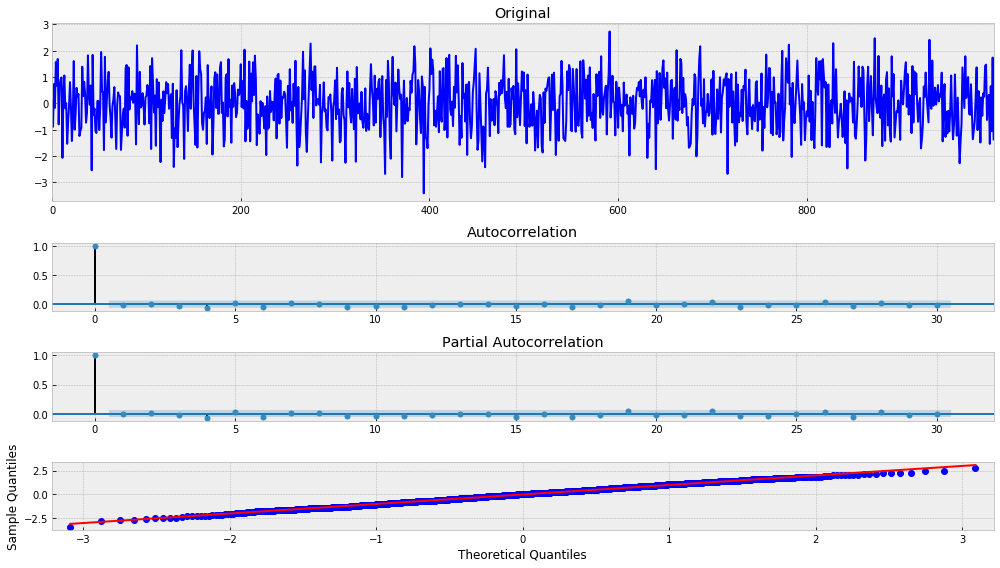

In [8]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


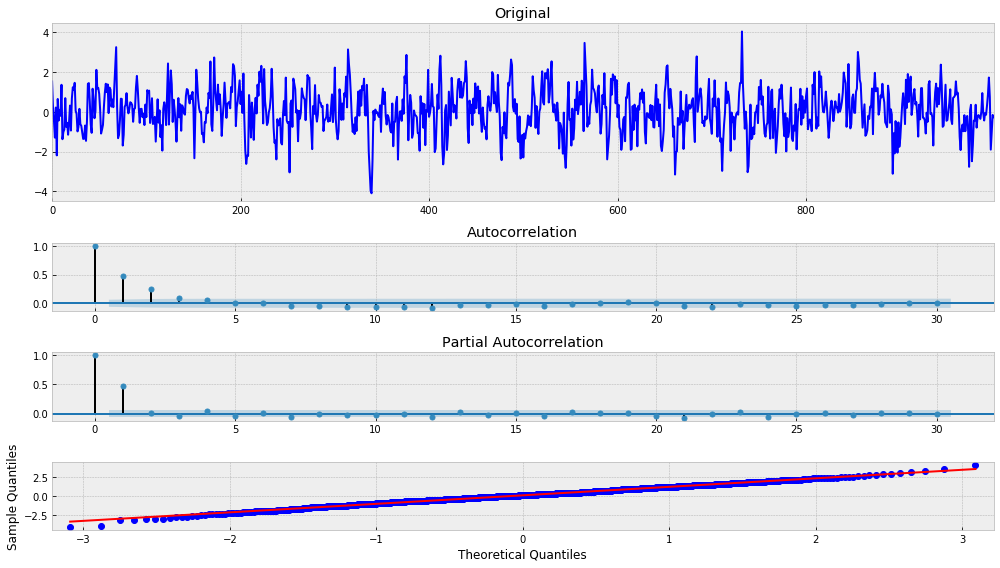

In [9]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [10]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


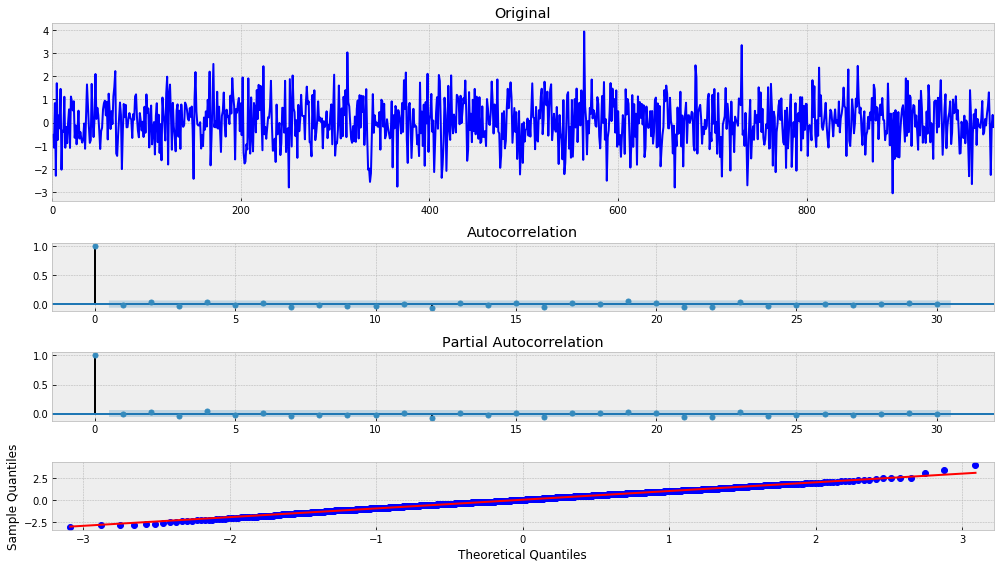

In [11]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


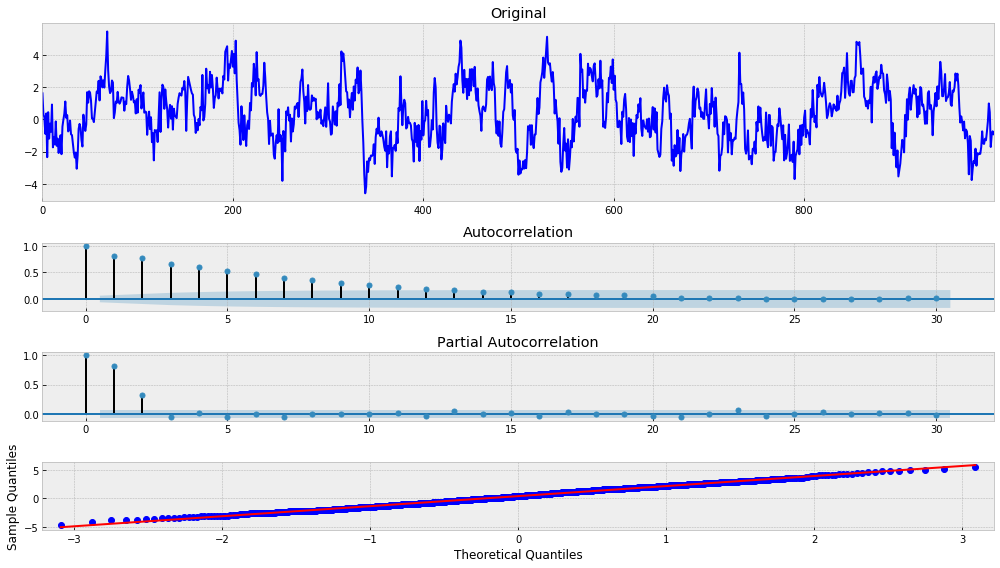

In [12]:
np.random.seed(1)
n_sample = 1000
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [13]:
mdl = smt.AR(x).fit(maxlag=3, trend='nc')

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


Results of Dickey-Fuller Test:
Test Statistic                 -31.609276
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


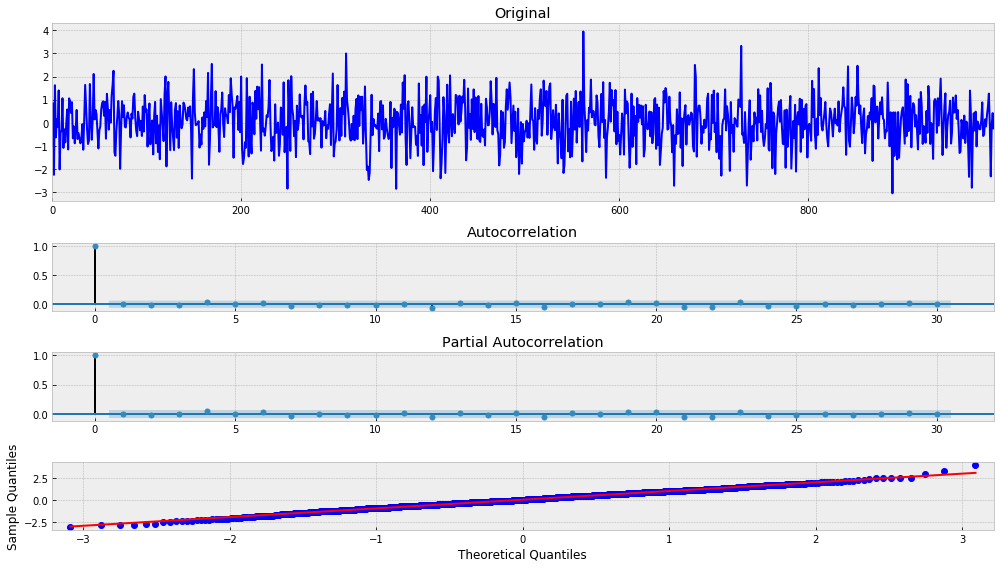

In [14]:
tsplot(mdl.resid, lags=30)

In [15]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


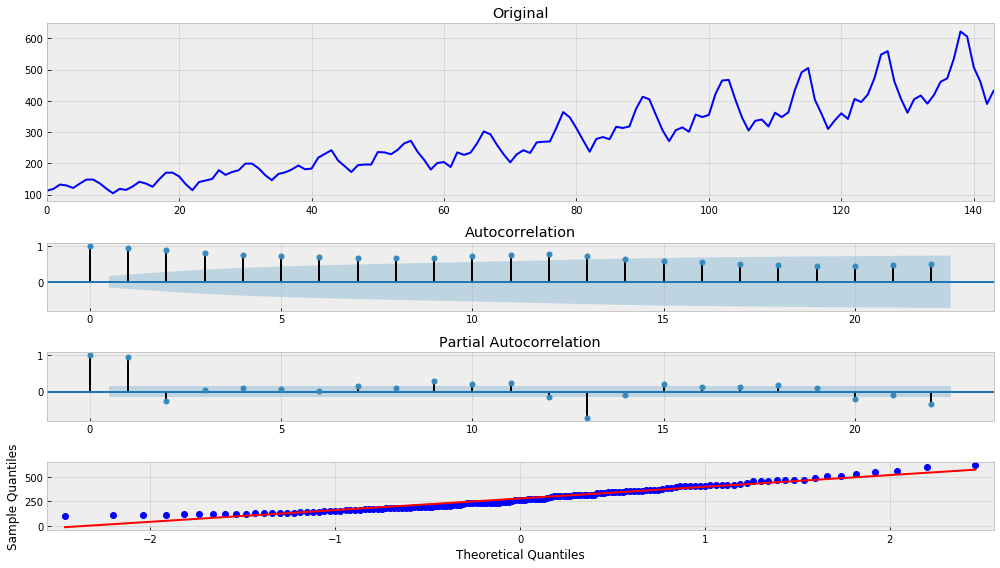

In [16]:
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


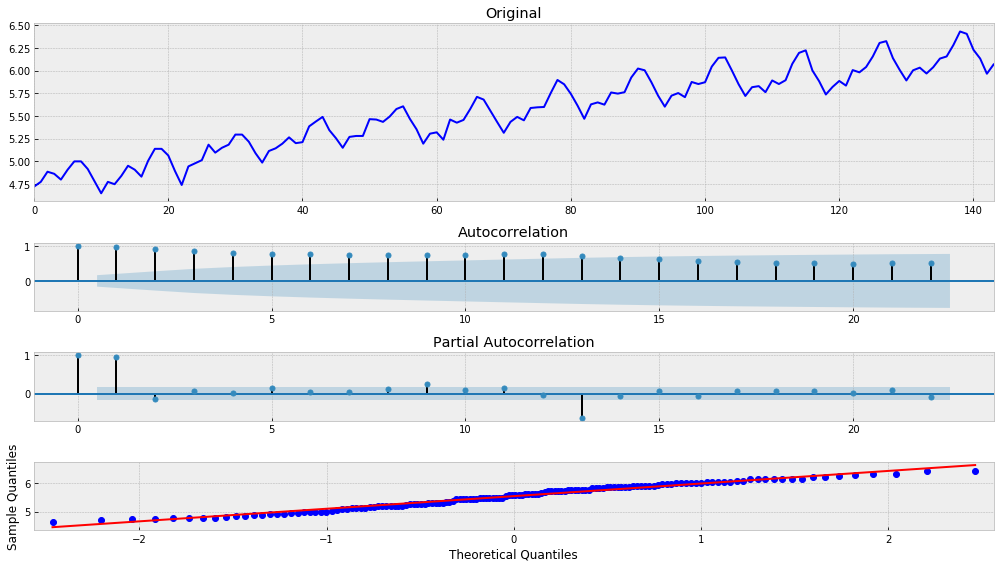

In [17]:
series = boxcox(series, 0) # выравниваем дисперсию во временном ряду
tsplot(series)

In [19]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[ 0.57771154  0.22901853  0.06195854 -0.08919923  0.24920719 -0.15657936
  0.04266833 -0.01690364  0.24480034 -0.29458944  0.03968739  0.48535593
 -0.13295218 -0.31857377  0.17769943 -0.12830694 -0.00824594 -0.12456788
  0.17055048 -0.20087872  0.00313821  0.07960796  0.21843347  0.19825546
 -0.12661933 -0.17744898]


Results of Dickey-Fuller Test:
Test Statistic                -1.077826e+01
p-value                        2.290070e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


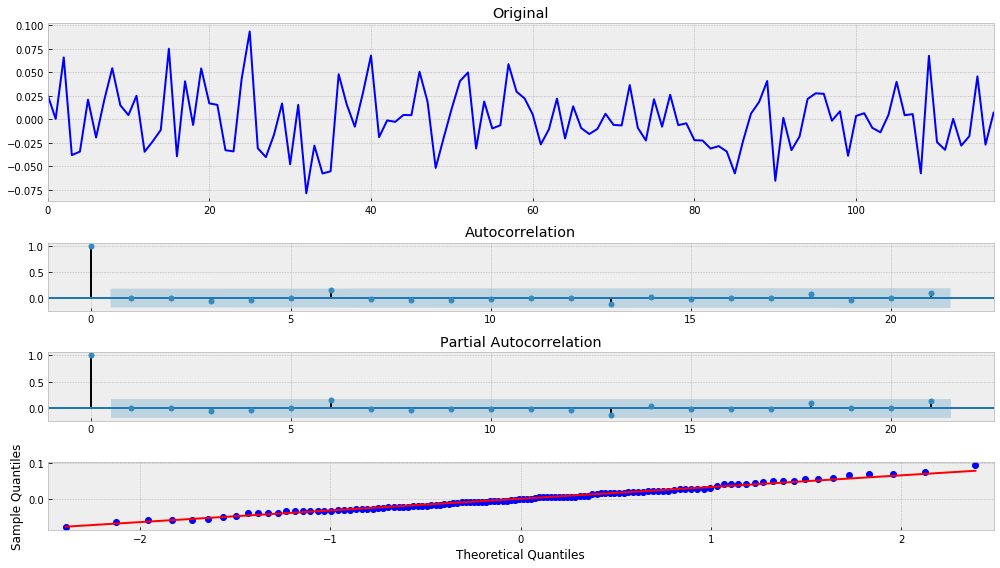

In [20]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


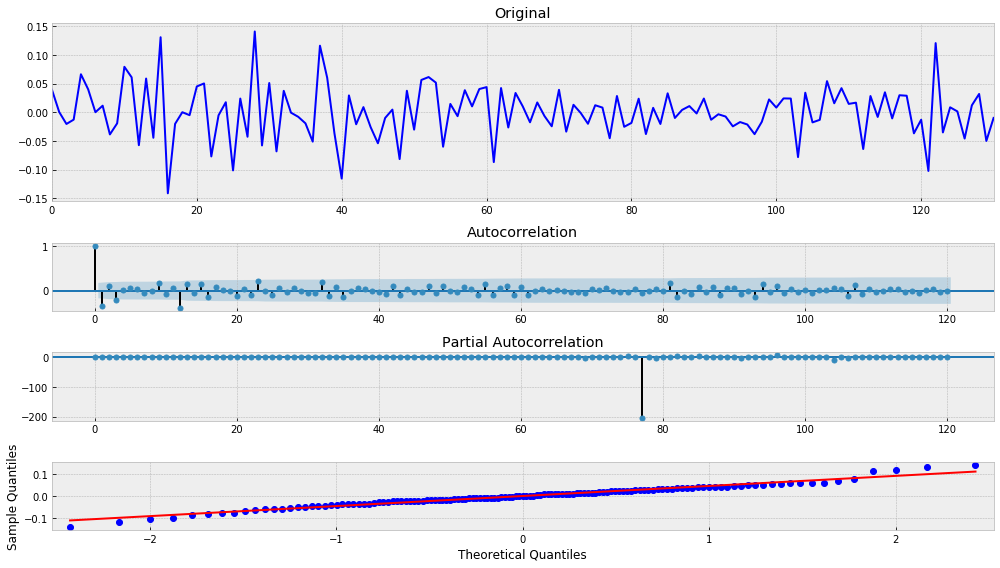

In [22]:
series_diff = np.diff(series)
series_diff = series_diff[12:] - series_diff[:-12]
tsplot(series_diff, lags=120)

In [27]:
mdl_diffed = smt.AR(series_diff).fit(maxlag=30, ic='aic', trend='nc')
print(mdl_diffed.params)

[-0.44356319 -0.04674482 -0.13346706 -0.11109479  0.03302162  0.03112745
 -0.06515299  0.03505331  0.16104996 -0.00834682 -0.11144103 -0.42633578
 -0.13933338]


Results of Dickey-Fuller Test:
Test Statistic                -1.084592e+01
p-value                        1.572554e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


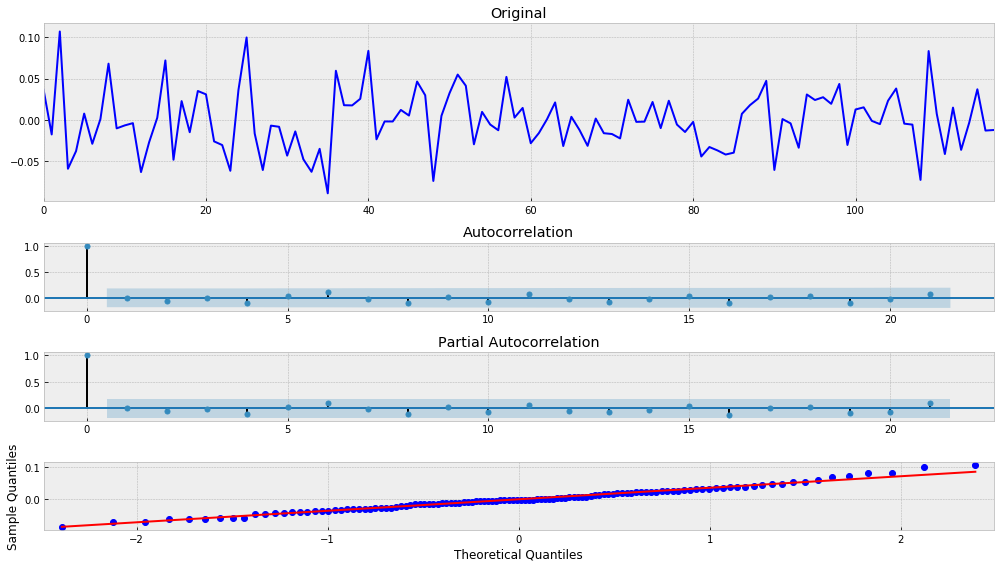

In [29]:
tsplot(mdl_diffed.resid)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARIMA

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7105.938
Method:                           mle   S.D. of innovations              1.002
Date:                Mon, 24 Feb 2020   AIC                          14221.876
Time:                        21:14:26   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                                                                              
              

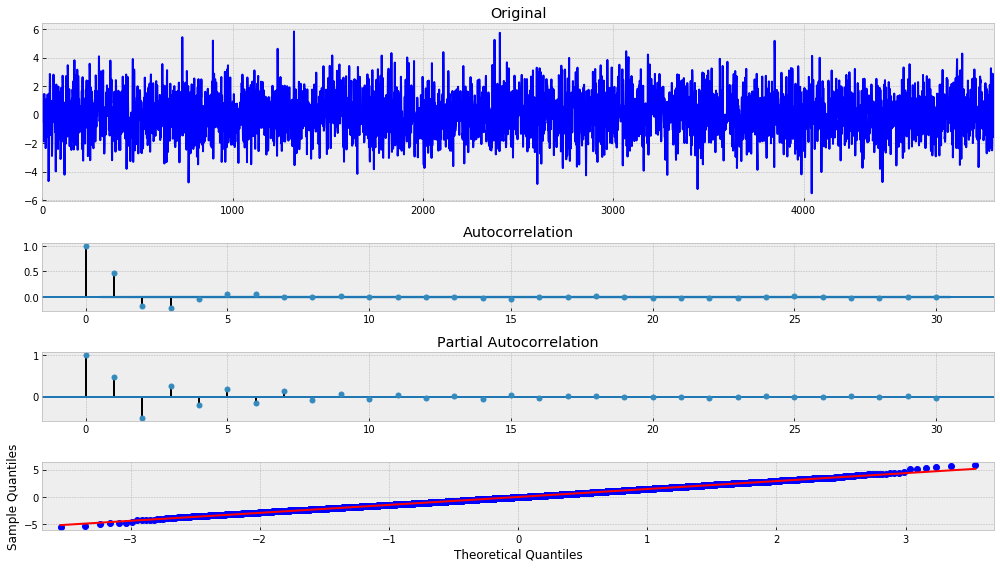

In [30]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

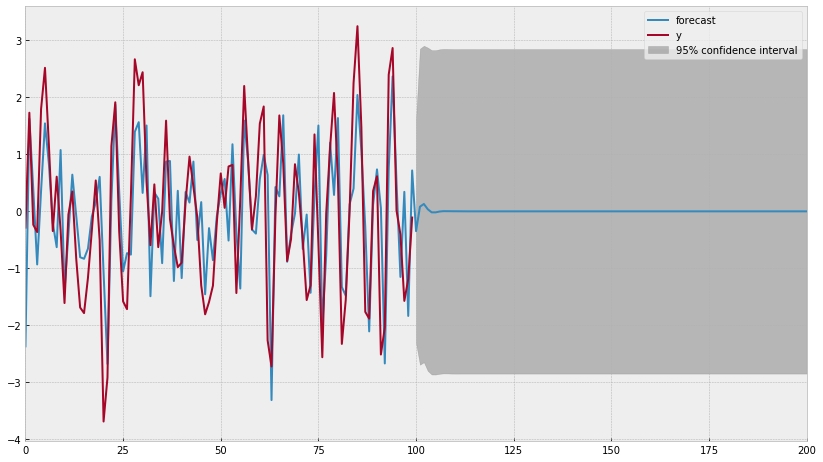

In [31]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax=plt.axes()
    mdl.plot_predict(start=4900, end=5100, ax=ax)

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [38]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 14221.50753 | order: (3, 3)


Применим модель ARMA к нашей TS

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


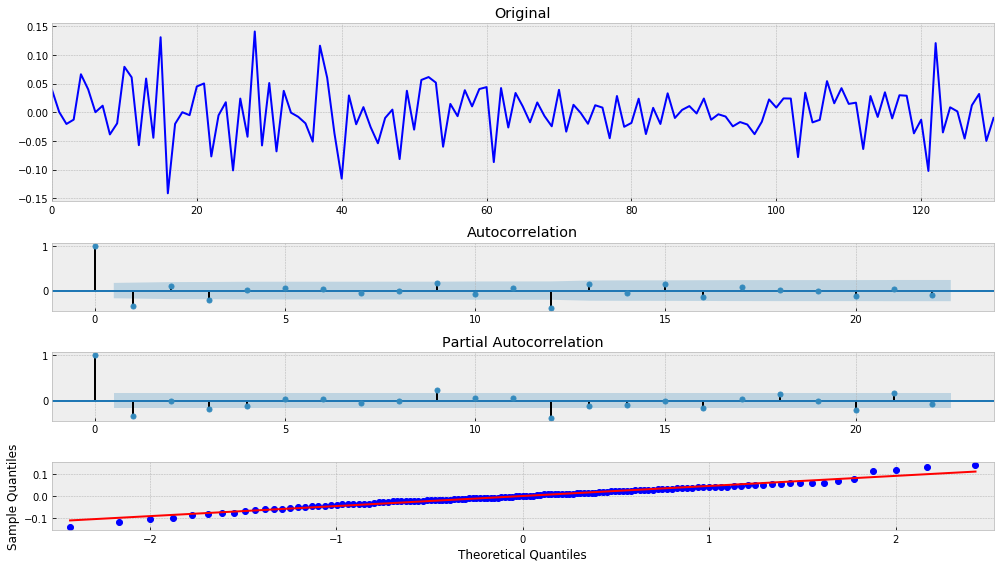

In [33]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [37]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -461.63880 | order: (4, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -4.343350
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


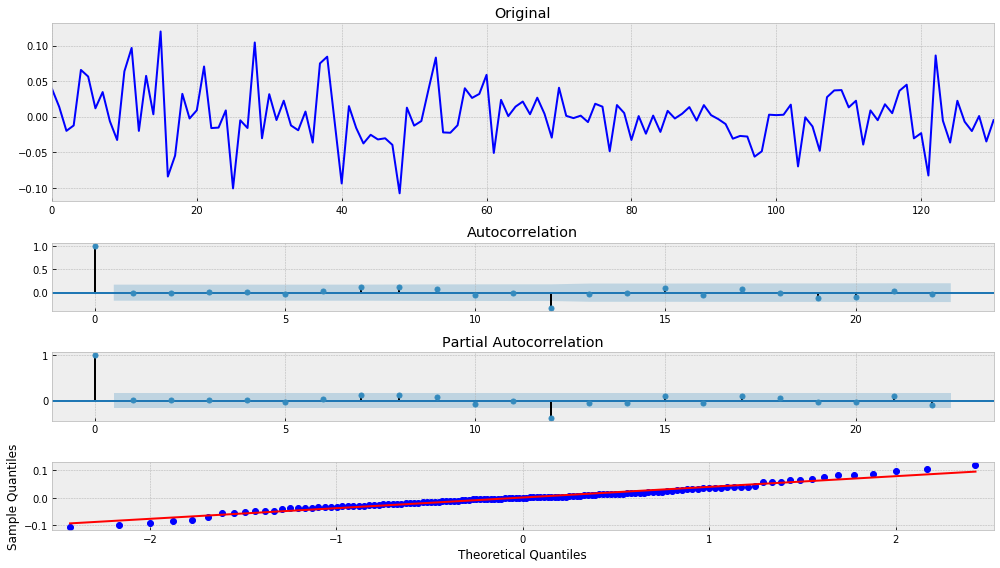

In [35]:
mdl = smt.ARMA(series, order=(4, 4)).fit(
                method='mle', trend='nc')
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

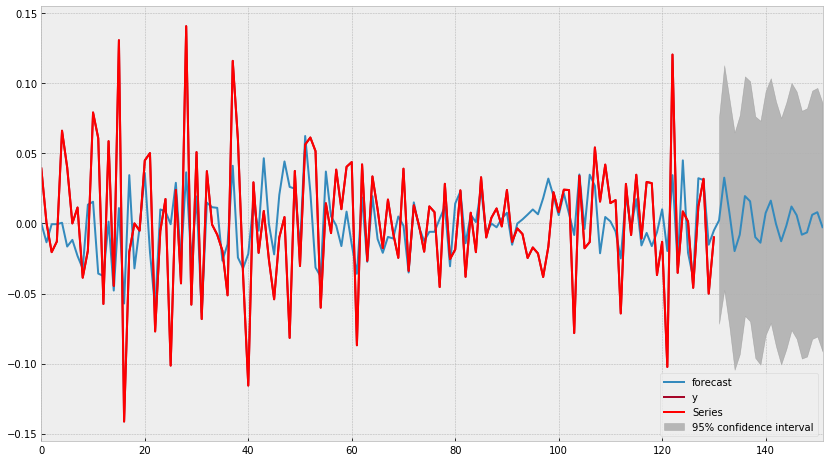

In [36]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params

aic: -461.63880 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.343350
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


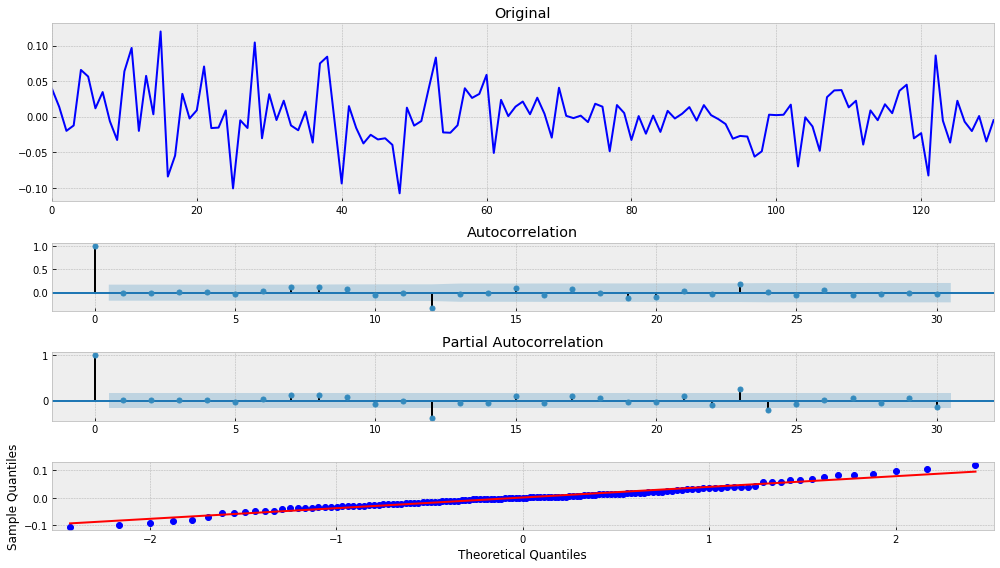

In [39]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

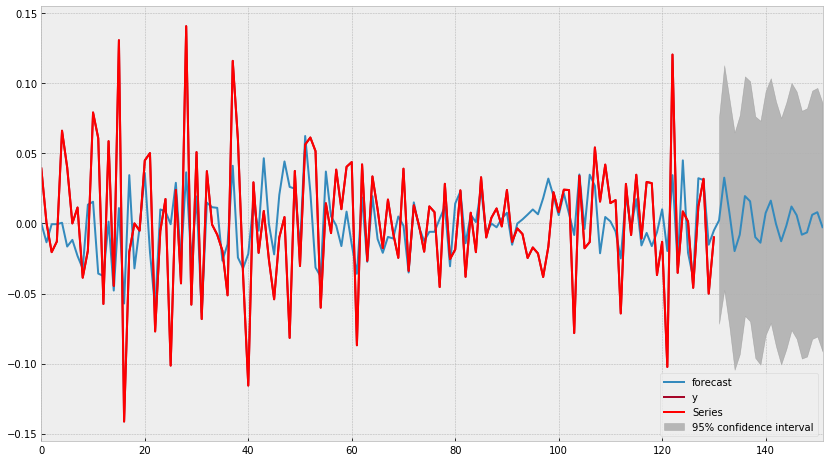

In [40]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


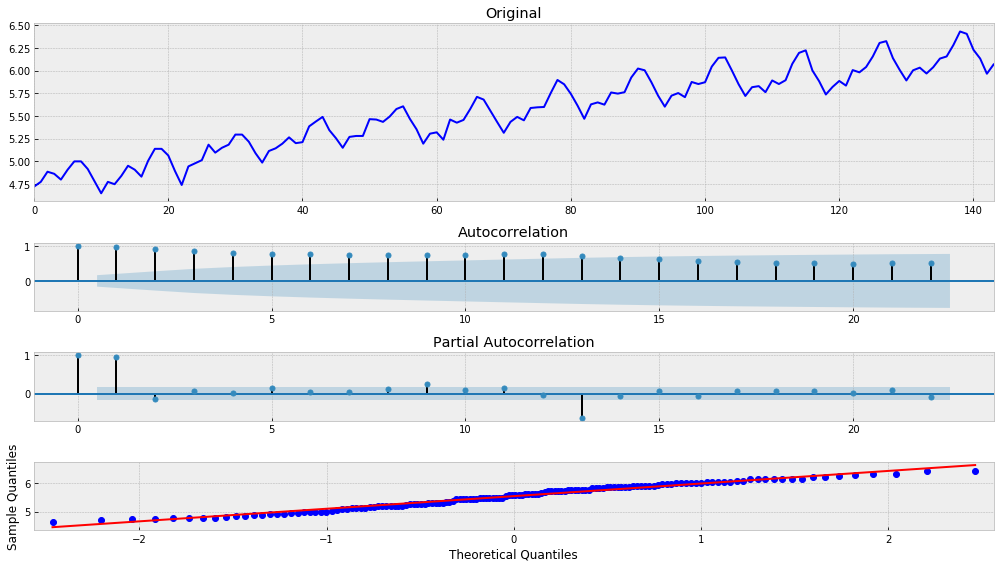

In [41]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
# без дифференцирования
tsplot(series)

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -294.55785 | order: (4, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -2.256855
p-value                          0.186261
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


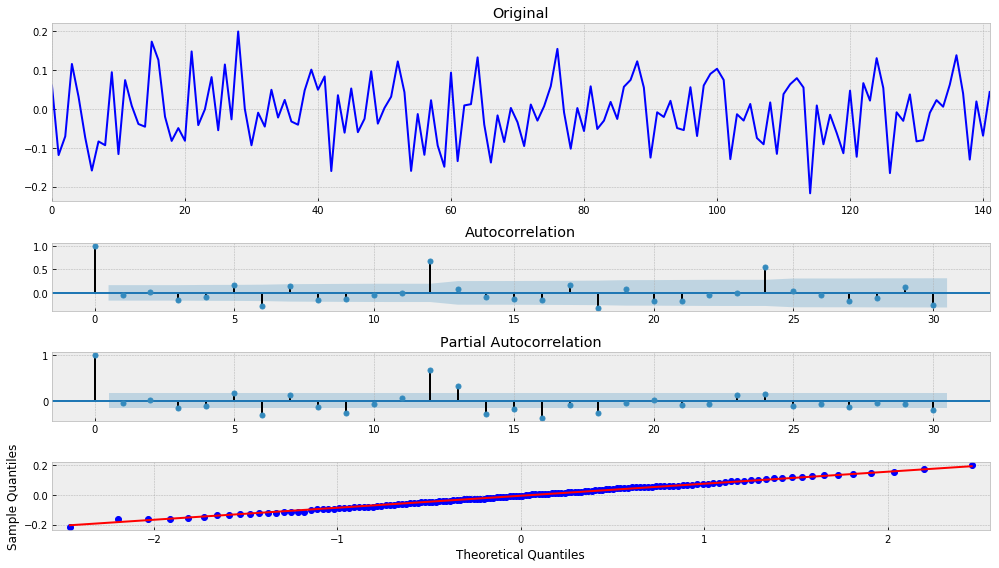

In [42]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


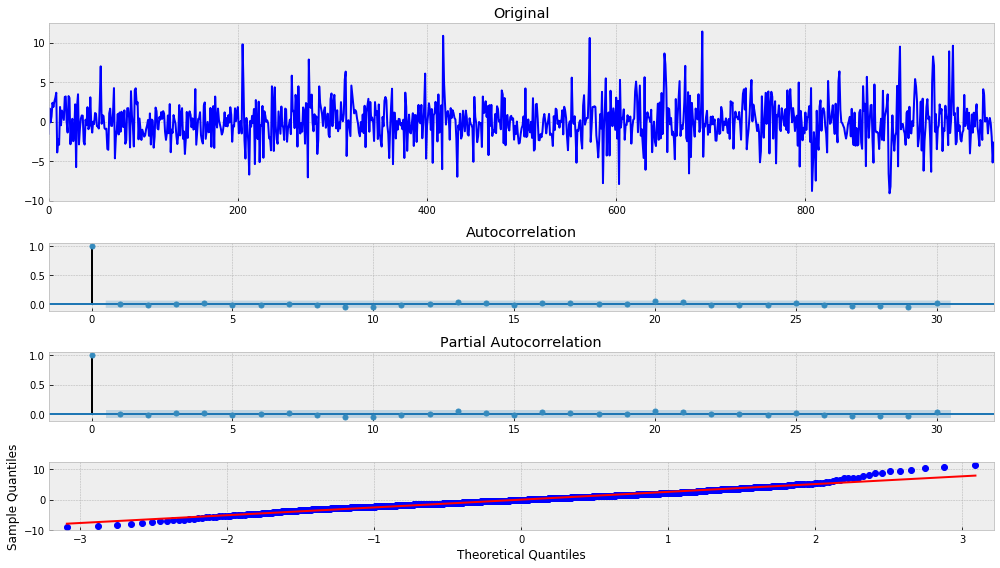

In [46]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [49]:
# !pip install arch

In [48]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.277625
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


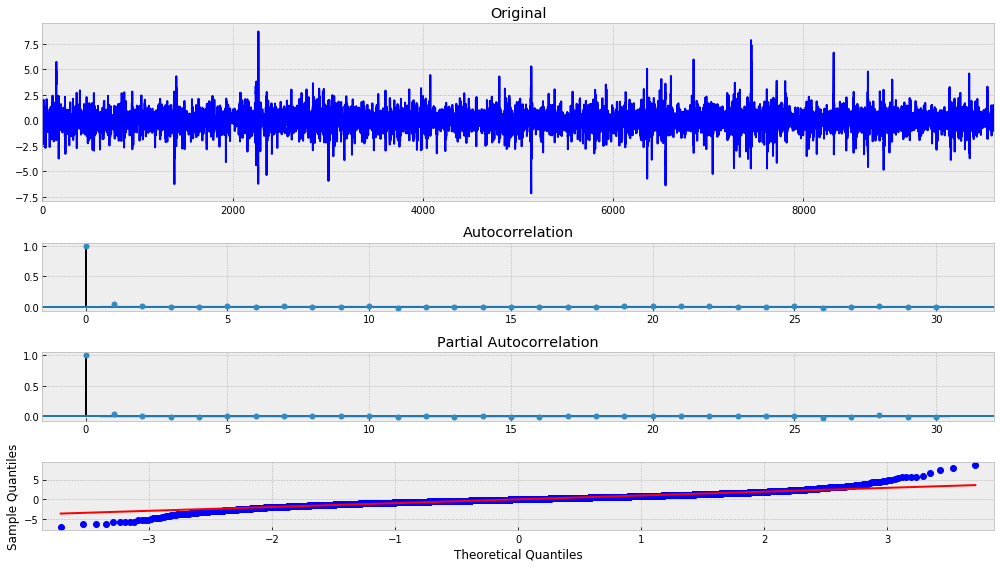

In [51]:
# Simulating a GARCH (1, 1) process

np.random.seed(2)

a0=0.2
a1=0.5
b1=0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(n):
    sigsq[i] = a0 + a1 * (eps[i-1]**2) + b1 * sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [52]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12312.309742091358
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12239.009860767315
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.716478067545
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.7
Distribution:                  Normal   AIC:                           24483.4
Method:            Maximum Likelihood   BIC:                           24512.3
                                        No. Observations:                10000
Date:                Mon, Feb 24 2020   Df Residuals:                     9996
Time:      

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [53]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: -294.55785 | order: (4, 2, 4)


/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Results of Dickey-Fuller Test:
Test Statistic                  -2.256855
p-value                          0.186261
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


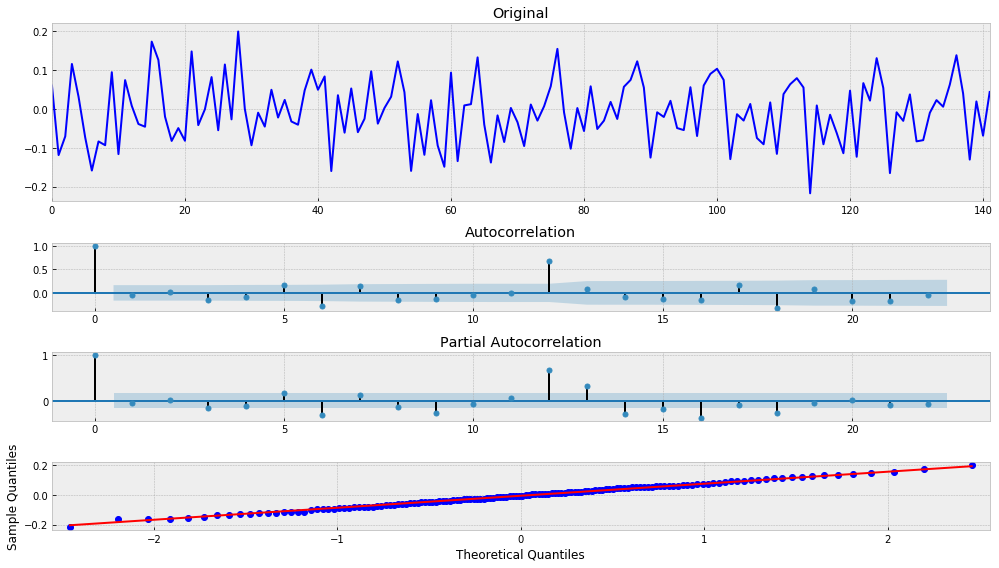

In [54]:
tsplot(mdl.resid)

Применим GARCH

In [55]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.032
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.032
Vol Model:                        GJR-GARCH   Log-Likelihood:               -46.7085
Distribution:      Standardized Student's t   AIC:                           119.417
Method:                  Maximum Likelihood   BIC:                           158.025
                                              No. Observations:                  144
Date:                      Mon, Feb 24 2020   Df Residuals:                      131
Time:                              21:59:36   Df Model:                           13
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


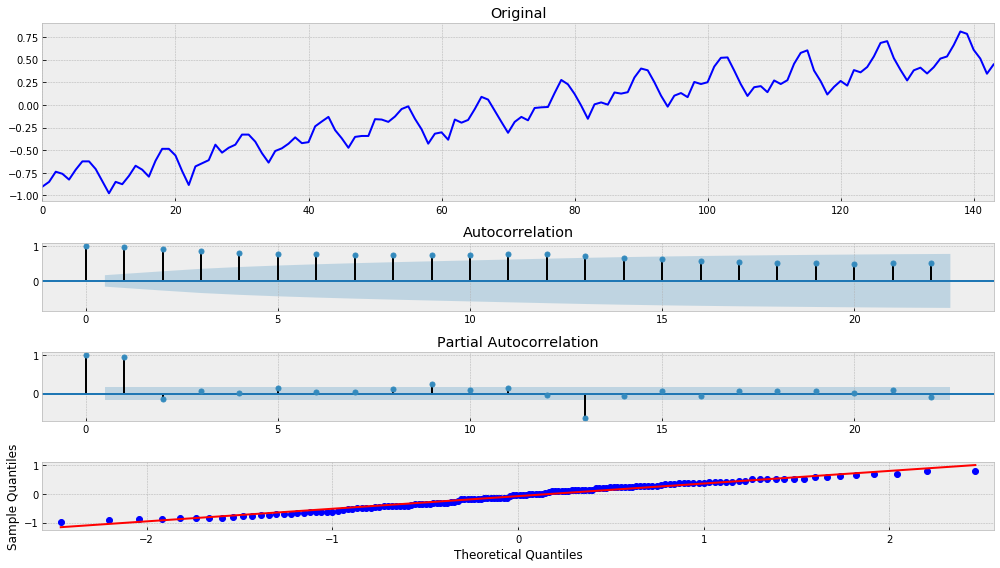

In [56]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


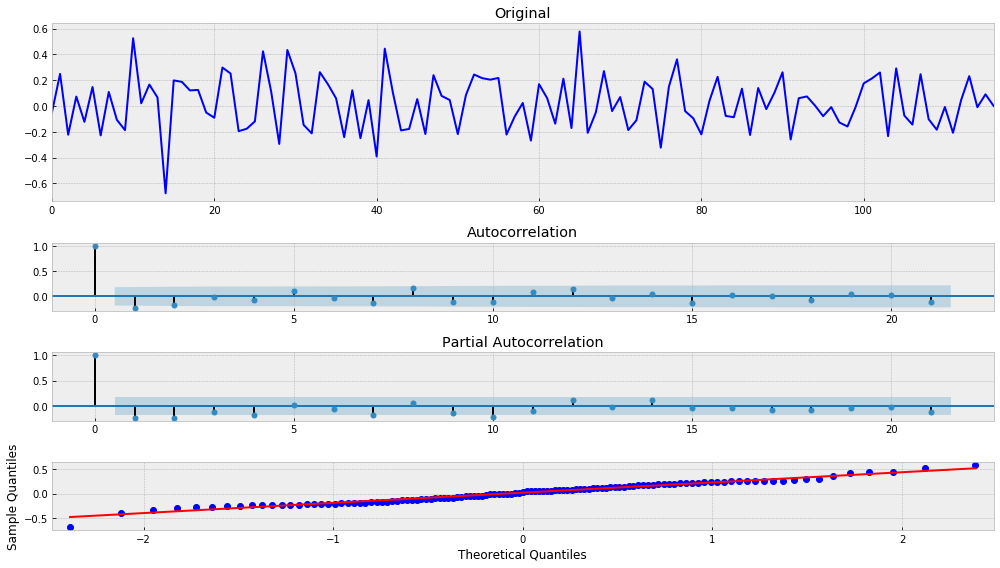

In [57]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [58]:
aic, order, mdl = _get_best_model(new_series)

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or

aic: -43.76715 | order: (4, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.124484e+01
p-value                        1.770094e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


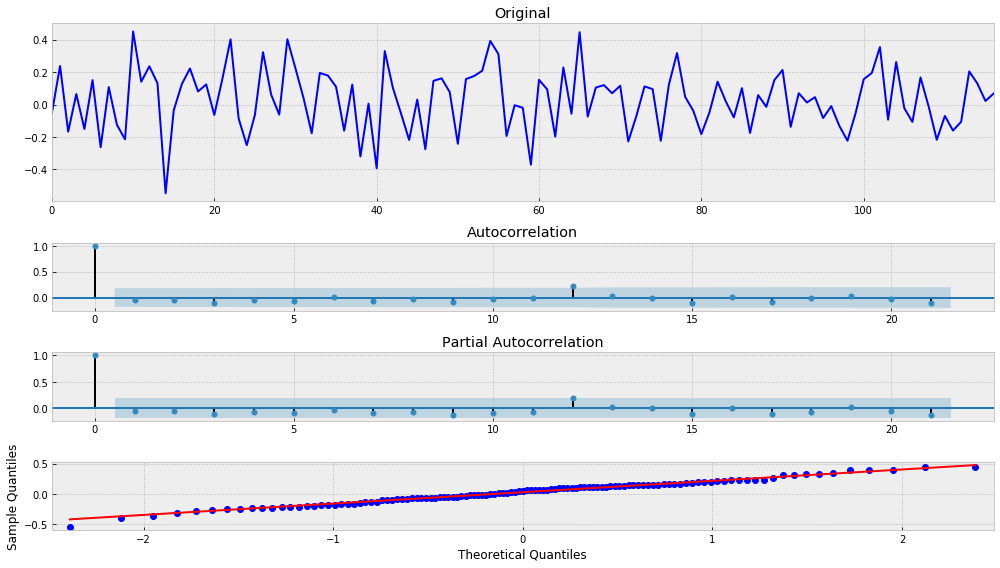

In [59]:
tsplot(mdl.resid)

In [61]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: -19.280779692584584
Iteration:     10,   Func. Count:    121,   Neg. LLF: -20.20235059259913
Iteration:     15,   Func. Count:    176,   Neg. LLF: -20.59911353080606
Iteration:     20,   Func. Count:    231,   Neg. LLF: -20.69193764203506
Iteration:     25,   Func. Count:    290,   Neg. LLF: -20.705455217493117
Iteration:     30,   Func. Count:    346,   Neg. LLF: -20.716061492531608
Iteration:     35,   Func. Count:    405,   Neg. LLF: -20.7192611320751
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.719395137324966
            Iterations: 36
            Function evaluations: 427
            Gradient evaluations: 36
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:         

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


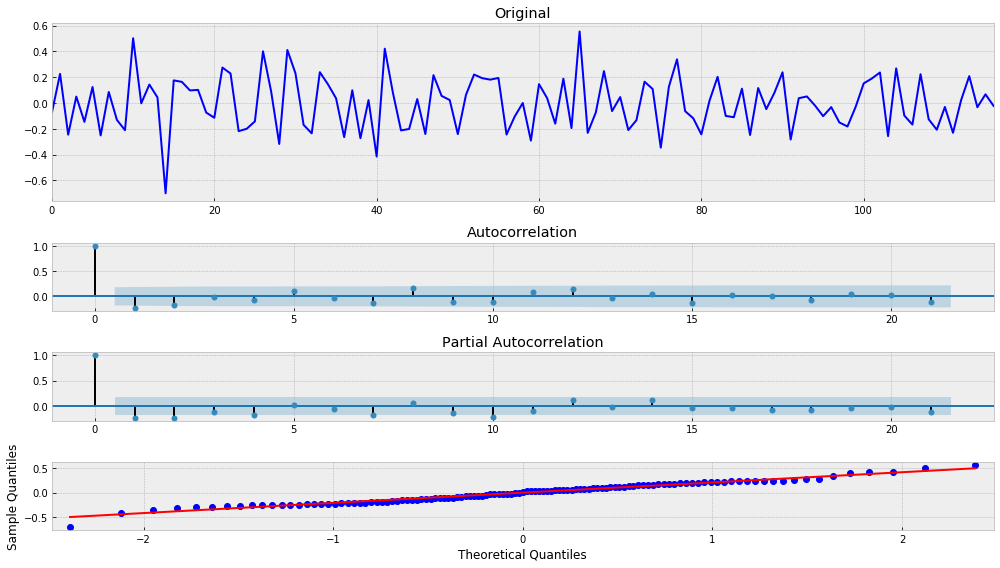

In [62]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [63]:
series = pd.read_csv("Series/international-airline-passengers.csv")

In [64]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [65]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

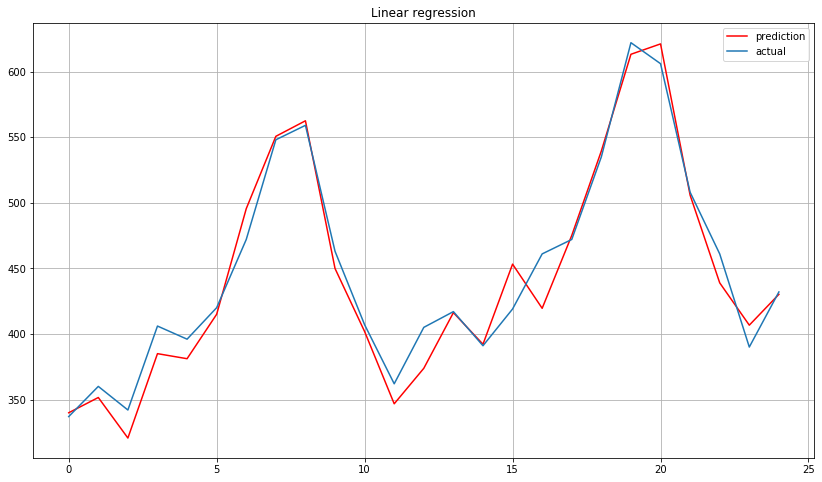

In [66]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [ ]:
pass